In [8]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
import os, math, cv2, glob, random, time
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../monkey10K"))

# Any results you write to the current directory are saved as output.

['monkey_labels.txt', 'training', '.ipynb_checkpoints', 'Untitled.ipynb', '10-monkey-species.zip', 'validation', 'Untitled1.ipynb']


In [18]:
train_dir = '../monkey10K/training/training/'
val_dir = '../monkey10K/validation/validation/'

In [13]:
labels = pd.read_csv("../monkey10K/monkey_labels.txt")
num_classes = labels['Label'].size
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [14]:
# for display images in notebook
from IPython.display import Image, display

from os import listdir
%matplotlib inline

In [15]:
IMAGE_WIDTH = 150
IMAGE_HEIGHT = 150
BATCH_SIZE = 24

In [16]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input


## use inception's own preprocess function
train_data_gen_aug=ImageDataGenerator(
                              preprocessing_function=preprocess_input,
                              rotation_range=20,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
#                               shear_range=0.2,
#                               horizontal_flip=True,
#                               fill_mode='nearest' # default is nearest
                             )

validation_data_gen=ImageDataGenerator(
                                       preprocessing_function=preprocess_input
                                      )

In [19]:
train_gen=train_data_gen_aug.flow_from_directory(train_dir,
                                            target_size=(IMAGE_WIDTH,
                                                       IMAGE_HEIGHT),
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            class_mode="categorical")
val_gen = validation_data_gen.flow_from_directory(val_dir, 
                                                    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT), 
                                                    batch_size = BATCH_SIZE, 
                                                    class_mode="categorical")

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [20]:
train_count=1097
val_count=272
steps_per_epoch=train_count//BATCH_SIZE
steps_per_epoch

45

In [22]:
from keras.applications import InceptionV3
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

# set  up the model
model=Sequential()
# add inception pretrained model, the wieghts 80Mb
model.add(InceptionV3(include_top=False, 
                      pooling='avg', 
                      weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
                     ))
# use relu as activation function "vanishing gradiends" :)
# model.add(Dense(2048, activation="relu"))  
# # add drop out to avoid overfitting
# model.add(Dropout(0.25))
model.add(Dense(num_classes, activation="softmax"))

In [23]:
model.layers[0].trainable=False

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
from keras import optimizers
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.00001)
# use adam to avoid overfitting

model.compile(loss="categorical_crossentropy",
              optimizer=adam,
              metrics=["accuracy"])

In [26]:
model_history = model.fit_generator(train_gen,
                                    steps_per_epoch=steps_per_epoch,
                                    epochs=48,
                                    validation_data=val_gen,
                                    validation_steps=val_count // BATCH_SIZE
                                   )

Epoch 1/48
45/45 [==============================] - 37s 818ms/step - loss: 2.4017 - accuracy: 0.1155 - val_loss: 3.0594 - val_accuracy: 0.1742
Epoch 2/48
45/45 [==============================] - 26s 579ms/step - loss: 2.2530 - accuracy: 0.1629 - val_loss: 3.2819 - val_accuracy: 0.2742
Epoch 3/48
45/45 [==============================] - 25s 560ms/step - loss: 2.1467 - accuracy: 0.2123 - val_loss: 2.1335 - val_accuracy: 0.3226
Epoch 4/48
45/45 [==============================] - 25s 564ms/step - loss: 2.0223 - accuracy: 0.2905 - val_loss: 1.9839 - val_accuracy: 0.4234
Epoch 5/48
45/45 [==============================] - 24s 543ms/step - loss: 1.9640 - accuracy: 0.3175 - val_loss: 2.1011 - val_accuracy: 0.4960
Epoch 6/48
45/45 [==============================] - 25s 551ms/step - loss: 1.8646 - accuracy: 0.3948 - val_loss: 2.3348 - val_accuracy: 0.5403
Epoch 7/48
45/45 [==============================] - 22s 500ms/step - loss: 1.8229 - accuracy: 0.4041 - val_loss: 1.4921 - val_accuracy: 0.6089

In [27]:
model.save('incept_adv.h5') 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

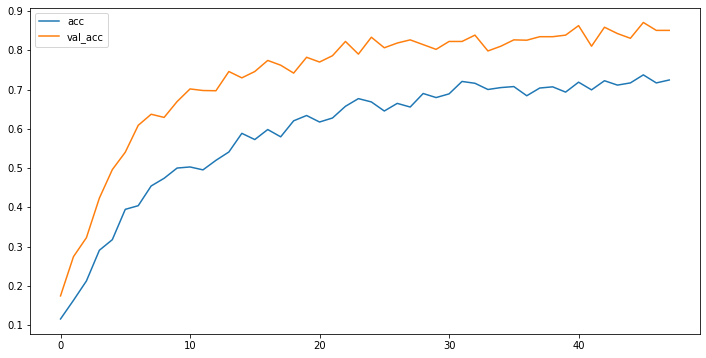

In [36]:
import pandas as pd
history = pd.DataFrame()
history["acc"] = model_history.history["accuracy"]
history["val_acc"] = model_history.history["val_accuracy"]
history.plot(figsize=(12, 6))
model_history.history.keys()

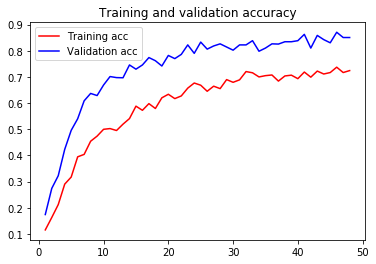

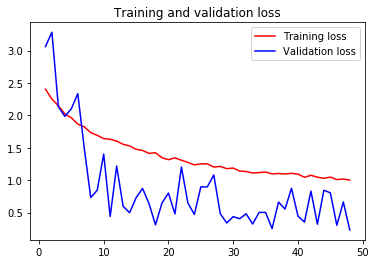

In [38]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(acc) + 1)

import matplotlib.pyplot as plt

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()